# Group 18 Proposal - Credit card score and Education Levels



Dataset Link : http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

### Introduction:
When signing up for a credit card one receives a limit based on the card signed up for and credit score. Many struggle to manage their spendings, especially when financially independent. This is due to bills that need to be tracked if one is to pay off accrued credit card debt. Typically, those with a higher education level tend to earn higher income (CBC News, 2016) and are thus able to pay off credit card debt as well as have a higher credit limit. Those with a education level of highschool graduate or lower tend to earn less and have less opportunity for financial growth (Indeed Editorial Team, 2021) and therefore may struggle to pay back their debt and have a lower credit limit.
Can we predict a person's education based on how much of their credit limit they spend and how much they pay back?
We will use the "default of credit card clients Data Set" from UCI to answer this. Attributes included in the dataset are the amount of credit given, which includes an individual's credit limit, supplementary family credit, gender, education, marital status, age, payment history, amount of bill statement, and amount of previous payment.

### Methods and Results

In [ ]:
#### Dependencies and Packages:

In [34]:
# RUN THIS FIRST
install.packages('patchwork')
install.packages('expss')
library(readxl)
library(tidyverse)
library(repr)
library(tidymodels)
library(patchwork)
library(expss)
set.seed(1234) # DO NOT CHANGE FOR RESULTS TO BE REPLICABLE

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘checkmate’, ‘foreign’, ‘htmlTable’, ‘matrixStats’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Use 'expss_output_viewer()' to display tables in the RStudio Viewer.
 To return to the console output, use 'expss_output_default()'.



Attaching package: ‘expss’


The following object is masked from ‘package:recipes’:

    fixed


The following object is masked from ‘package:infer’:

    calculate


The following objects are masked from ‘package:stringr’:

    fixed, regex


The following objects are masked from ‘package:dplyr’:

    between, compute, contains, first, last, na_if, recode, vars


The following objects are masked from ‘package:purrr’:

    keep, modify, modify_if, transpose, when


The following objects are masked from ‘package:tidyr’:

    contains, nest


The following object is masked from ‘package:ggplot2’:

    vars




#### Reading The Data From the Web:

In [37]:
# Data from Citation #1
temp <- tempfile()
download.file("http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",temp)
credit <- read_excel(temp,skip = 1)
unlink(temp)

In [39]:
head(credit,n=3) %>%
    set_caption('Table 1.0 Raw Credit Data from UCI')

Table 1.0 Raw Credit Data from UCI# A tibble: 3 x 25
     ID LIMIT_BAL   SEX EDUCATION MARRIAGE   AGE PAY_0 PAY_2 PAY_3 PAY_4 PAY_5 PAY_6 BILL_AMT1 BILL_AMT2 BILL_AMT3 BILL_AMT4 BILL_AMT5 BILL_AMT6 PAY_AMT1 PAY_AMT2 PAY_AMT3 PAY_AMT4 PAY_AMT5 PAY_AMT6 `default payment next month`
  <dbl>     <dbl> <dbl>     <dbl>    <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>     <dbl>     <dbl>     <dbl>     <dbl>     <dbl>     <dbl>    <dbl>    <dbl>    <dbl>    <dbl>    <dbl>    <dbl>                        <dbl>
1     1     20000     2         2        1    24     2     2    -1    -1    -2    -2      3913      3102       689         0         0         0        0      689        0        0        0        0                            1
2     2    120000     2         2        2    26    -1     2     0     0     0     2      2682      1725      2682      3272      3455      3261        0     1000     1000     1000        0     2000                            1
3     3     90000     2         2        2    34     0     0     0     0     0     0     29239     14027     13559     14331     14948     15549     1518     1500     1000     1000     1000     5000                            0

#### Cleaning and Wrangling Data:
- ```EDUCATION``` values can be observed to go up to 6, however they were only proper documentation in categorizing up to 4. Seeing as how 4 corresponds to "other" we have decided to only take education values from 1-3. \
Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- Some of the ```BILL_AMT``` vectors contained negative numbers. Negative balances are a rare occurence and only happen in strange circumstances so we will not be including them in our data set.
- ```BILL_AVG``` represents on average, throughout the six months what fraction of their credit limit has a person racked up in bills.
- There are several cases of abnormally high BILL_AVG and PAY_AVG values, so we will be filtering those out as they can be considered outliers.
- Overall, the number of rows were reduced to 27603 from 30001 after cleaning and wrangling.

In [40]:
credit_rel <- credit %>%
    select(ID, LIMIT_BAL, EDUCATION, PAY_AMT1:PAY_AMT6, BILL_AMT1:BILL_AMT6) %>%
    filter(EDUCATION < 4, EDUCATION != 0) %>%
    filter_all(all_vars(. >= 0)) %>%
    mutate(PAY_AVG = (PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6)/6,
          BILL_AVG = (BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6)/6,
          BILL_AVG = BILL_AVG/LIMIT_BAL) %>%
          select(EDUCATION, PAY_AVG, BILL_AVG) %>%
          filter(PAY_AVG <= 100000, BILL_AVG <= 2)
credit_rel$EDUCATION <- as.factor(credit_rel$EDUCATION)
head(credit_rel,n=6) %>%
    set_caption('Table 1.1 Wrangled and Cleaned Credit Data')


Table 1.1 Wrangled and Cleaned Credit Data# A tibble: 6 x 3
  EDUCATION PAY_AVG BILL_AVG
  <fct>       <dbl>    <dbl>
1 2            115.   0.0642
2 2            833.   0.0237
3 2           1836.   0.188 
4 2           1398    0.771 
5 2           9842.   0.364 
6 1           1295.   0.794

#### Splitting the Data
- Since this dataset is sizeable (>27000 rows) the model is will be using a 60:40 training to testing split.


In [41]:
credit_split <- initial_split(credit_rel, prop = 0.6, strata = EDUCATION)
credit_train <- training(credit_split)
credit_test <- testing(credit_split)


#### Tabular Exploratory Data Analysis:
Upon initial tabular exploration, we see that majority of people in this dataset have finished university, followed by graduate school, then high school graduates. It can be observed that on average, higher education correlating to higher ```PAY_AVG```  and lower ```BILL_AVG``` values, meaning they pay more expensive bills and spent a lower fraction of their credit limit respectively.

In [42]:
credit_edu <- credit_train %>%
    group_by(EDUCATION) %>%
    summarize(COUNT = n(), PAY_AVG = mean(PAY_AVG), BILL_AVG = mean(BILL_AVG))
credit_edu %>%
    set_caption('Table 2.0 Credit Data Aggregated by Education Type')

`summarise()` ungrouping output (override with `.groups` argument)



Table 2.0 Credit Data Aggregated by Education Type# A tibble: 3 x 4
  EDUCATION COUNT PAY_AVG BILL_AVG
  <fct>     <int>   <dbl>    <dbl>
1 1          5801   6175.    0.294
2 2          7974   4607.    0.441
3 3          2788   4053.    0.456

#### Visual Exploratory Data Analysis:
```Figure 2.0``` tells us that a vast majority of people do not surpass their monthly credit limit, and most people spent between 0-10% of their credit limit. On the other hand, ```Figure 2.1``` indicates that very few people pay over 4000 dollars back to their credit card company and vast majority pay less than 100 dollars. In ```Figure 2.2``` below, is a scatterplot of the 2 predictors.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



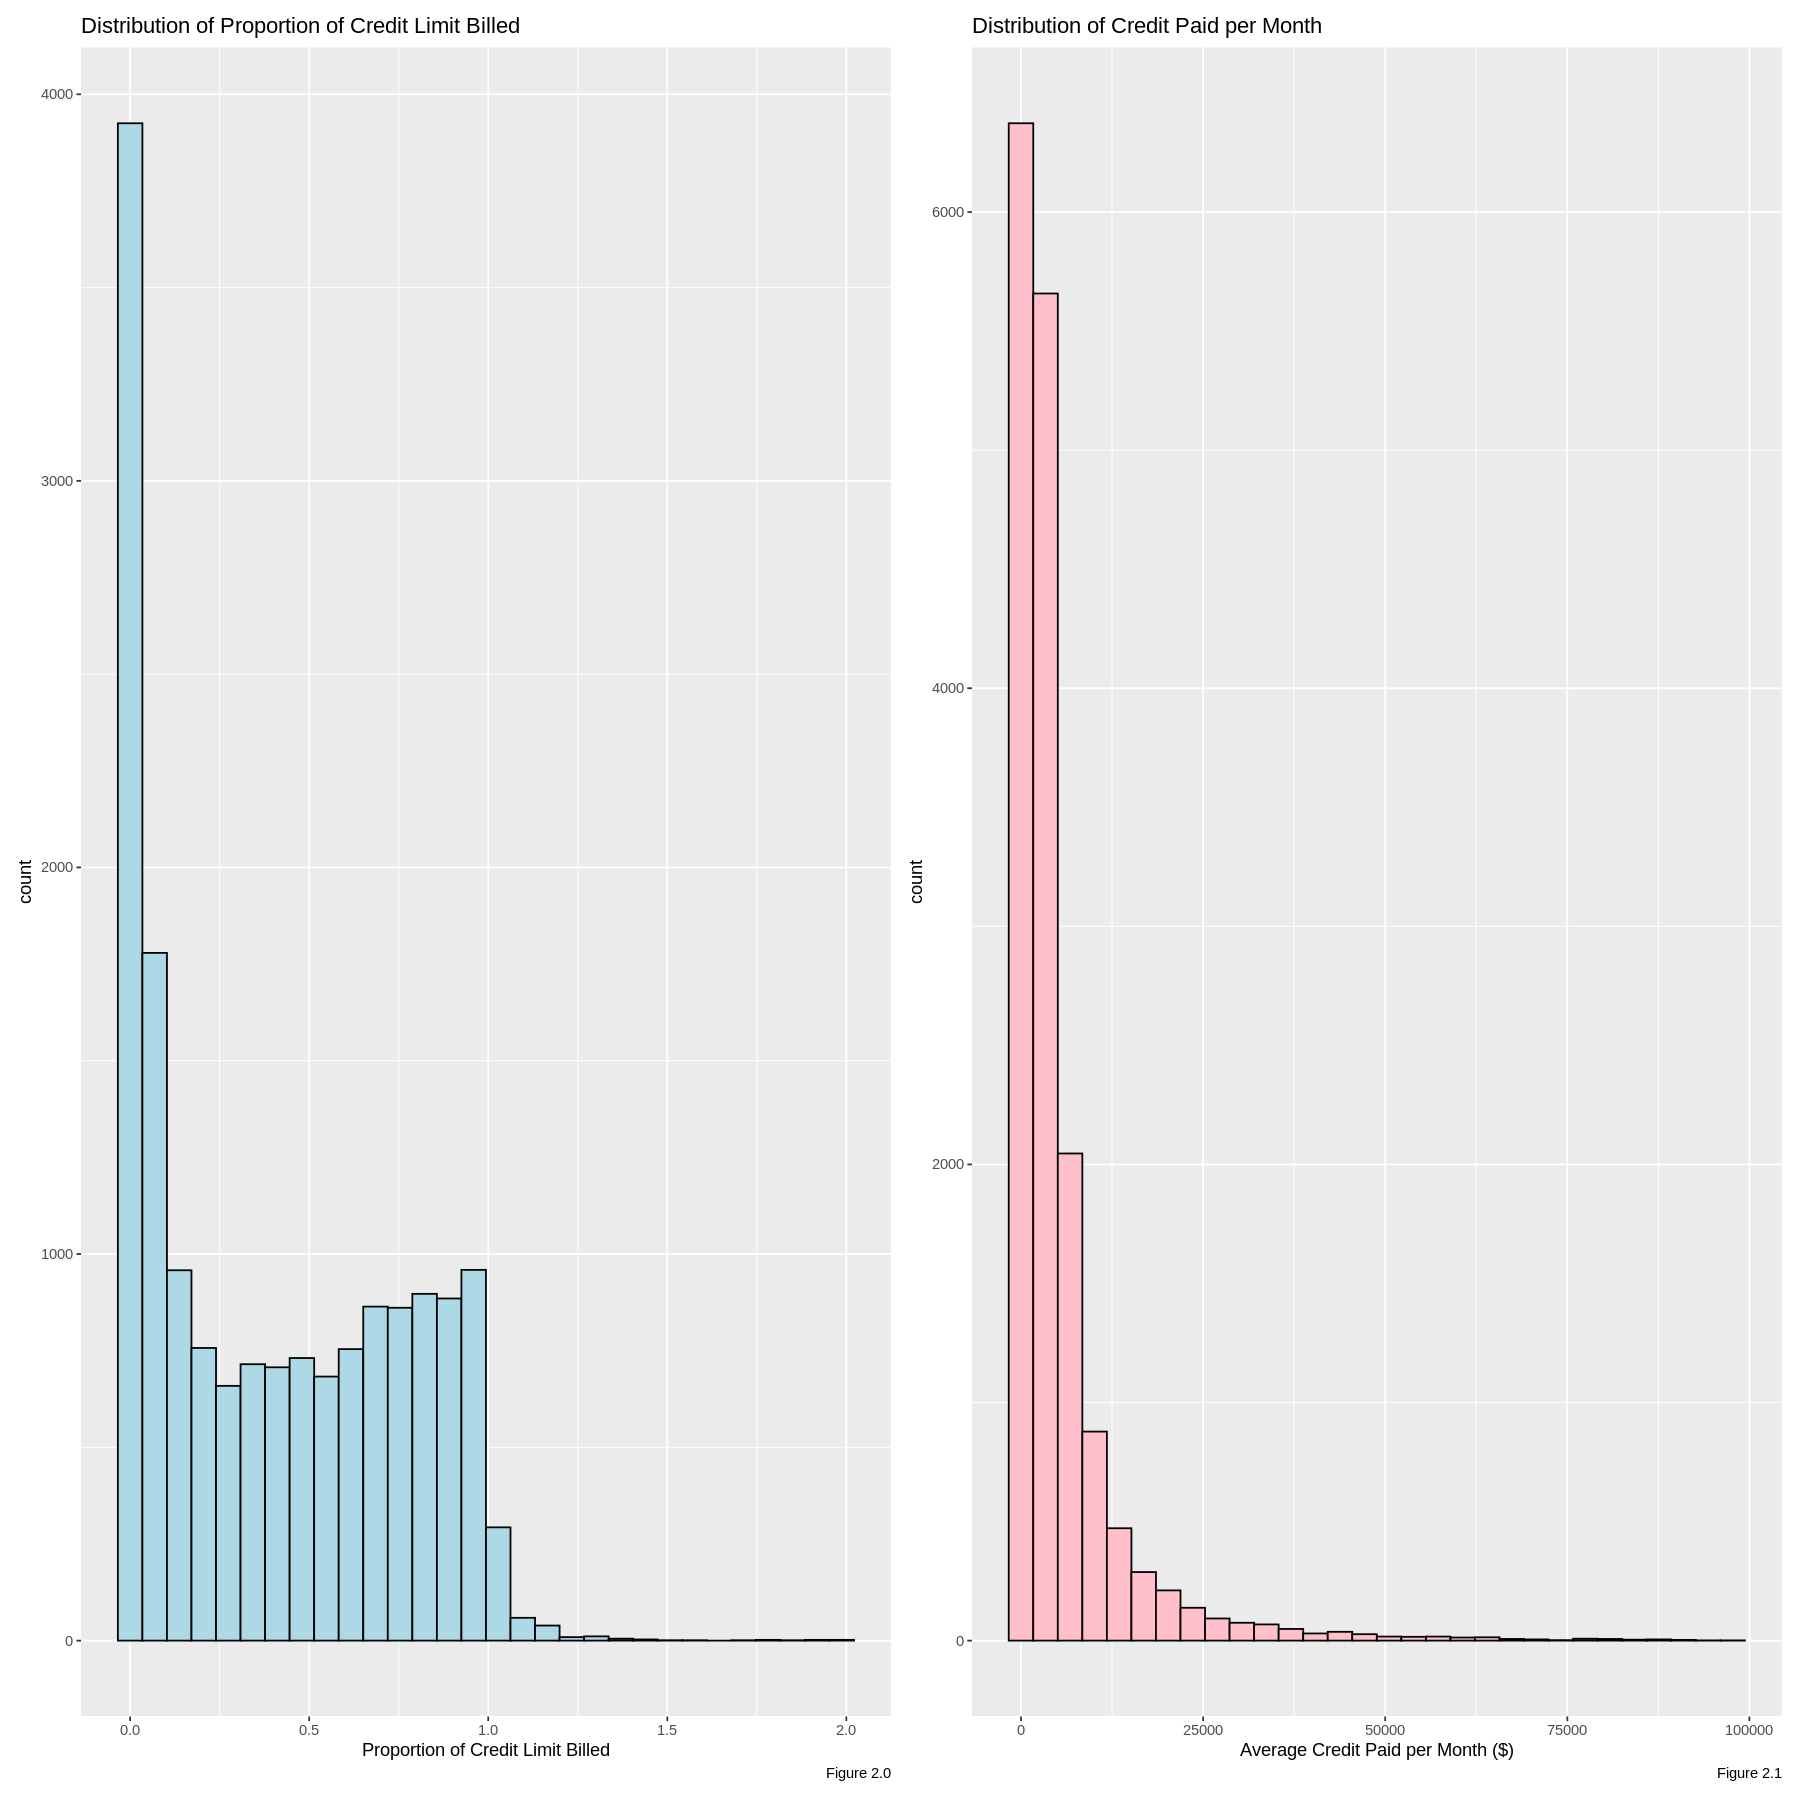

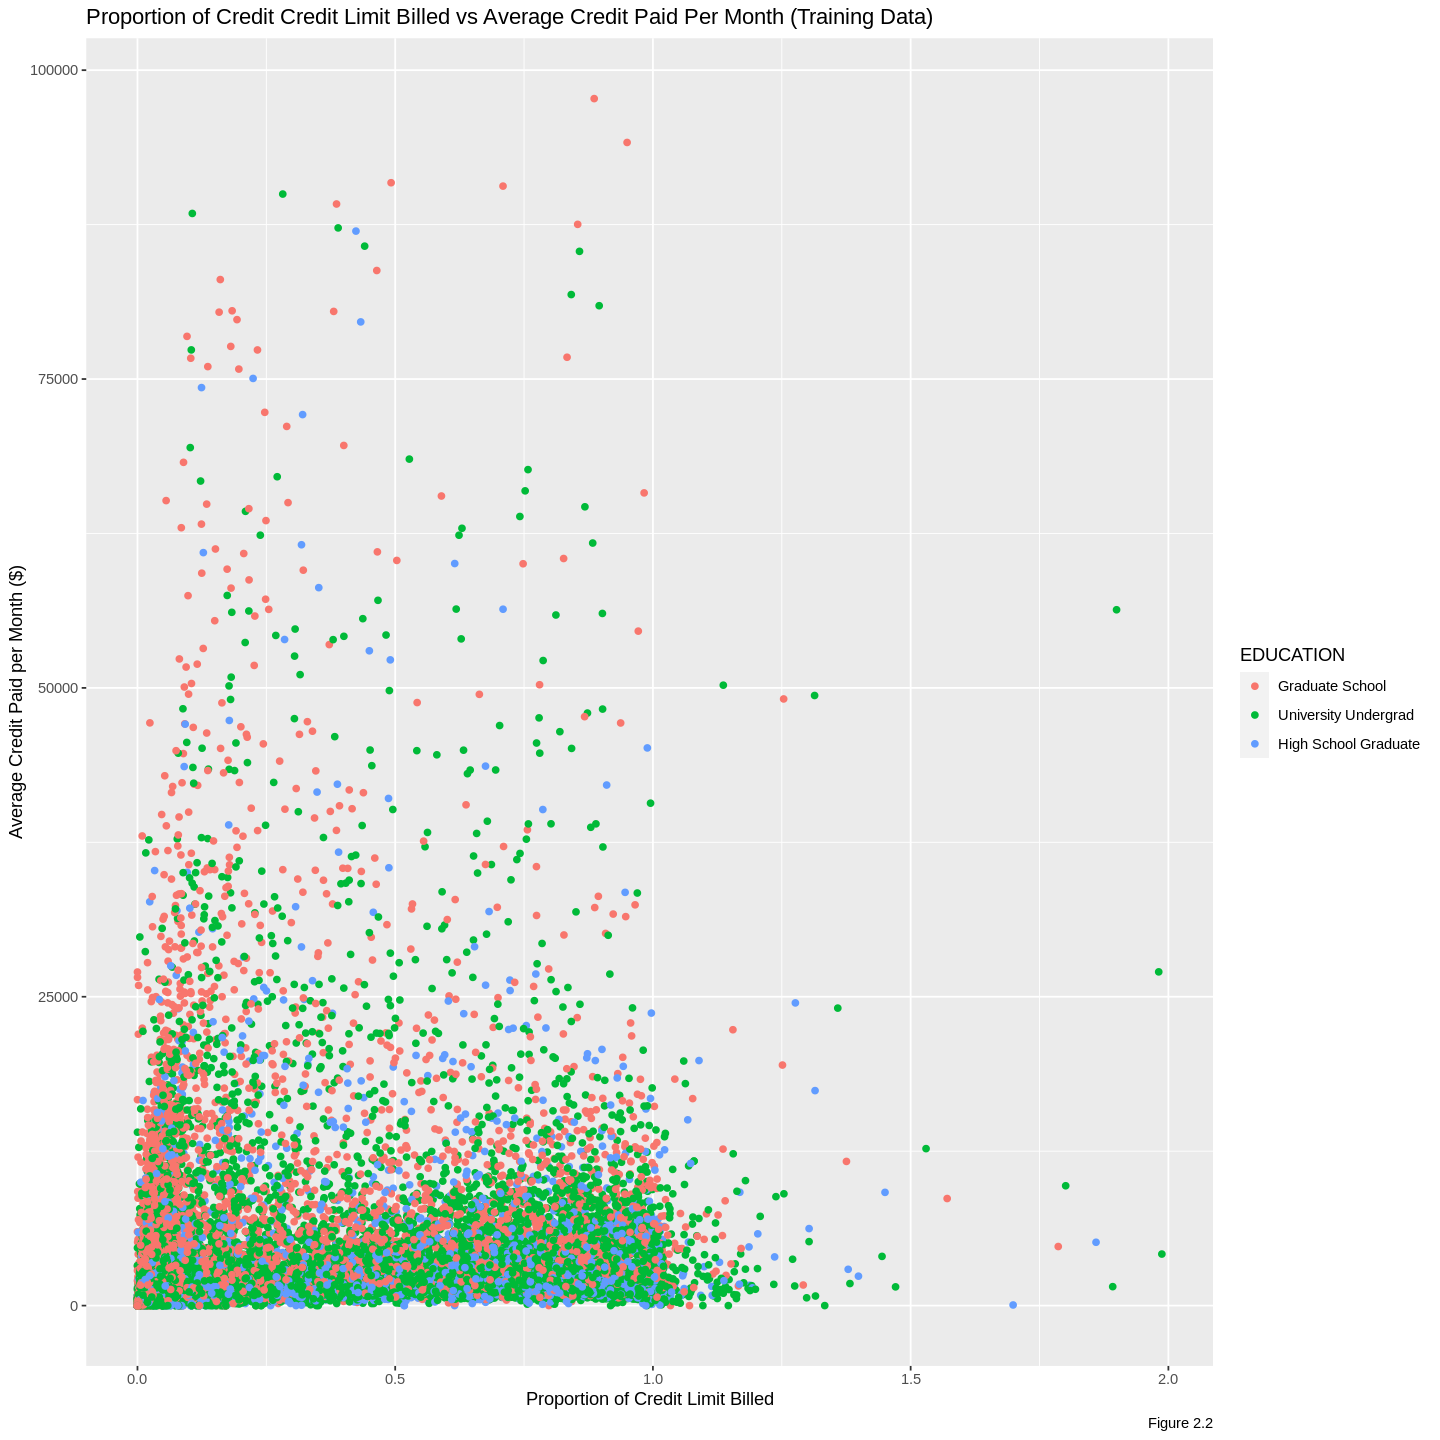

In [67]:
options(repr.plot.width = 15, repr.plot.height = 15)

bill_plot <- credit_train %>%
    ggplot(aes(x=BILL_AVG)) +
    geom_histogram(color='black',fill='light blue') +
    labs(x='Proportion of Credit Limit Billed', caption = 'Figure 2.0') +
    ggtitle('Distribution of Proportion of Credit Limit Billed')
pay_plot <- credit_train %>%
    ggplot(aes(x=PAY_AVG)) +
    geom_histogram(color='black',fill='pink') +
    labs(x='Average Credit Paid per Month ($)',caption = 'Figure 2.1') +
    ggtitle('Distribution of Credit Paid per Month')

bill_plot + pay_plot

options(repr.plot.width = 12, repr.plot.height = 12)
point_plot <- credit_train %>%
    ggplot(aes(x=BILL_AVG,y=PAY_AVG,colour = EDUCATION)) +
    geom_point() +
    labs(x='Proportion of Credit Limit Billed',y='Average Credit Paid per Month ($)', caption = 'Figure 2.2') +
    ggtitle('Proportion of Credit Credit Limit Billed vs Average Credit Paid Per Month (Training Data)') +
    scale_colour_discrete(labels = c("Graduate School","University Undergrad","High School Graduate"))

point_plot

#### Tuning The Model
We proceed to create a model specification with tuning on the number of neighbors, and perform a 5-fold cross-validation. All predictors are scaled in the recipe to ensure that the distance calculated in classification is normalized. A workflow analysis that adds the recipe and model specification, defines the tuning to 200 K values, and collects the metrics. In ```Figure 3.0 ```, we can observe a maxima at around 110-120. ```Figure 3.1``` represents ``` Figure 3.0```  narrowed down to ```K=100-120```. In that plot we observe that the K with the highest accuracy is 114. This is the value of K we shall proceed with in training the data for our final model. Here is the visual result of this step if you choose to not run the below code:
![Drag Racing](img/Figure3.0.png)


Warning message:
“Removed 179 rows containing missing values (geom_point).”
Warning message:
“Removed 179 row(s) containing missing values (geom_path).”


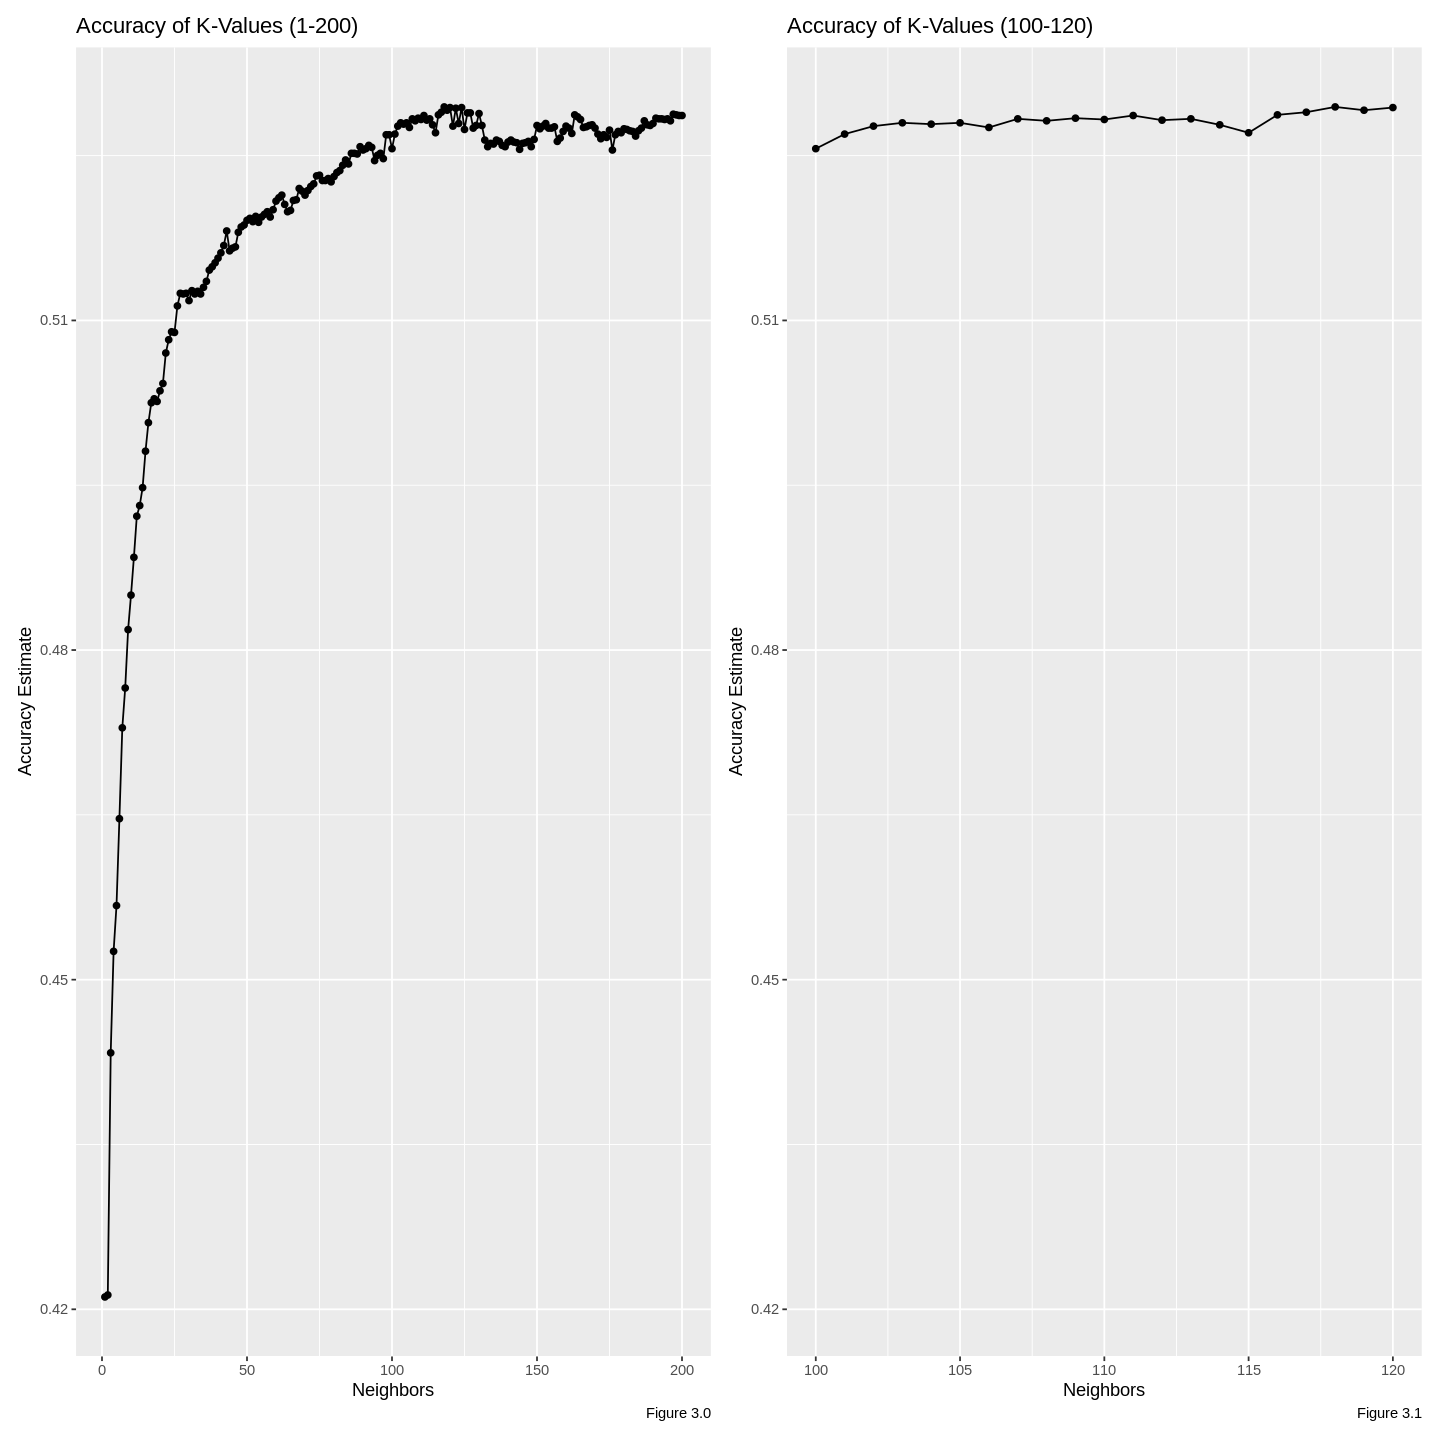

In [46]:
### THIS BLOCK MAY TAKE 1-2 HOURS TO RUN AS TUNING WITH A LARGE DATASET ON A 200-SIZE GRID IS COMPUTATIONALLY EXPENSIVE
knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
    set_engine('kknn') %>%
    set_mode('classification')
credit_recipe <- recipe(EDUCATION ~.,data = credit_train) %>%
   step_scale(all_predictors()) %>%
   step_center(all_predictors())
credit_vfold <- vfold_cv(credit_train, v=5, strata = EDUCATION)

k_vals <- tibble(neighbors = seq(from =1, to =200, by= 1))

knn_accuracy <- workflow() %>%
    add_recipe(credit_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = credit_vfold, grid = k_vals) %>%
    collect_metrics() %>%
    filter(.metric == 'accuracy')


Warning message:
“Removed 169 rows containing missing values (geom_point).”
Warning message:
“Removed 169 row(s) containing missing values (geom_path).”


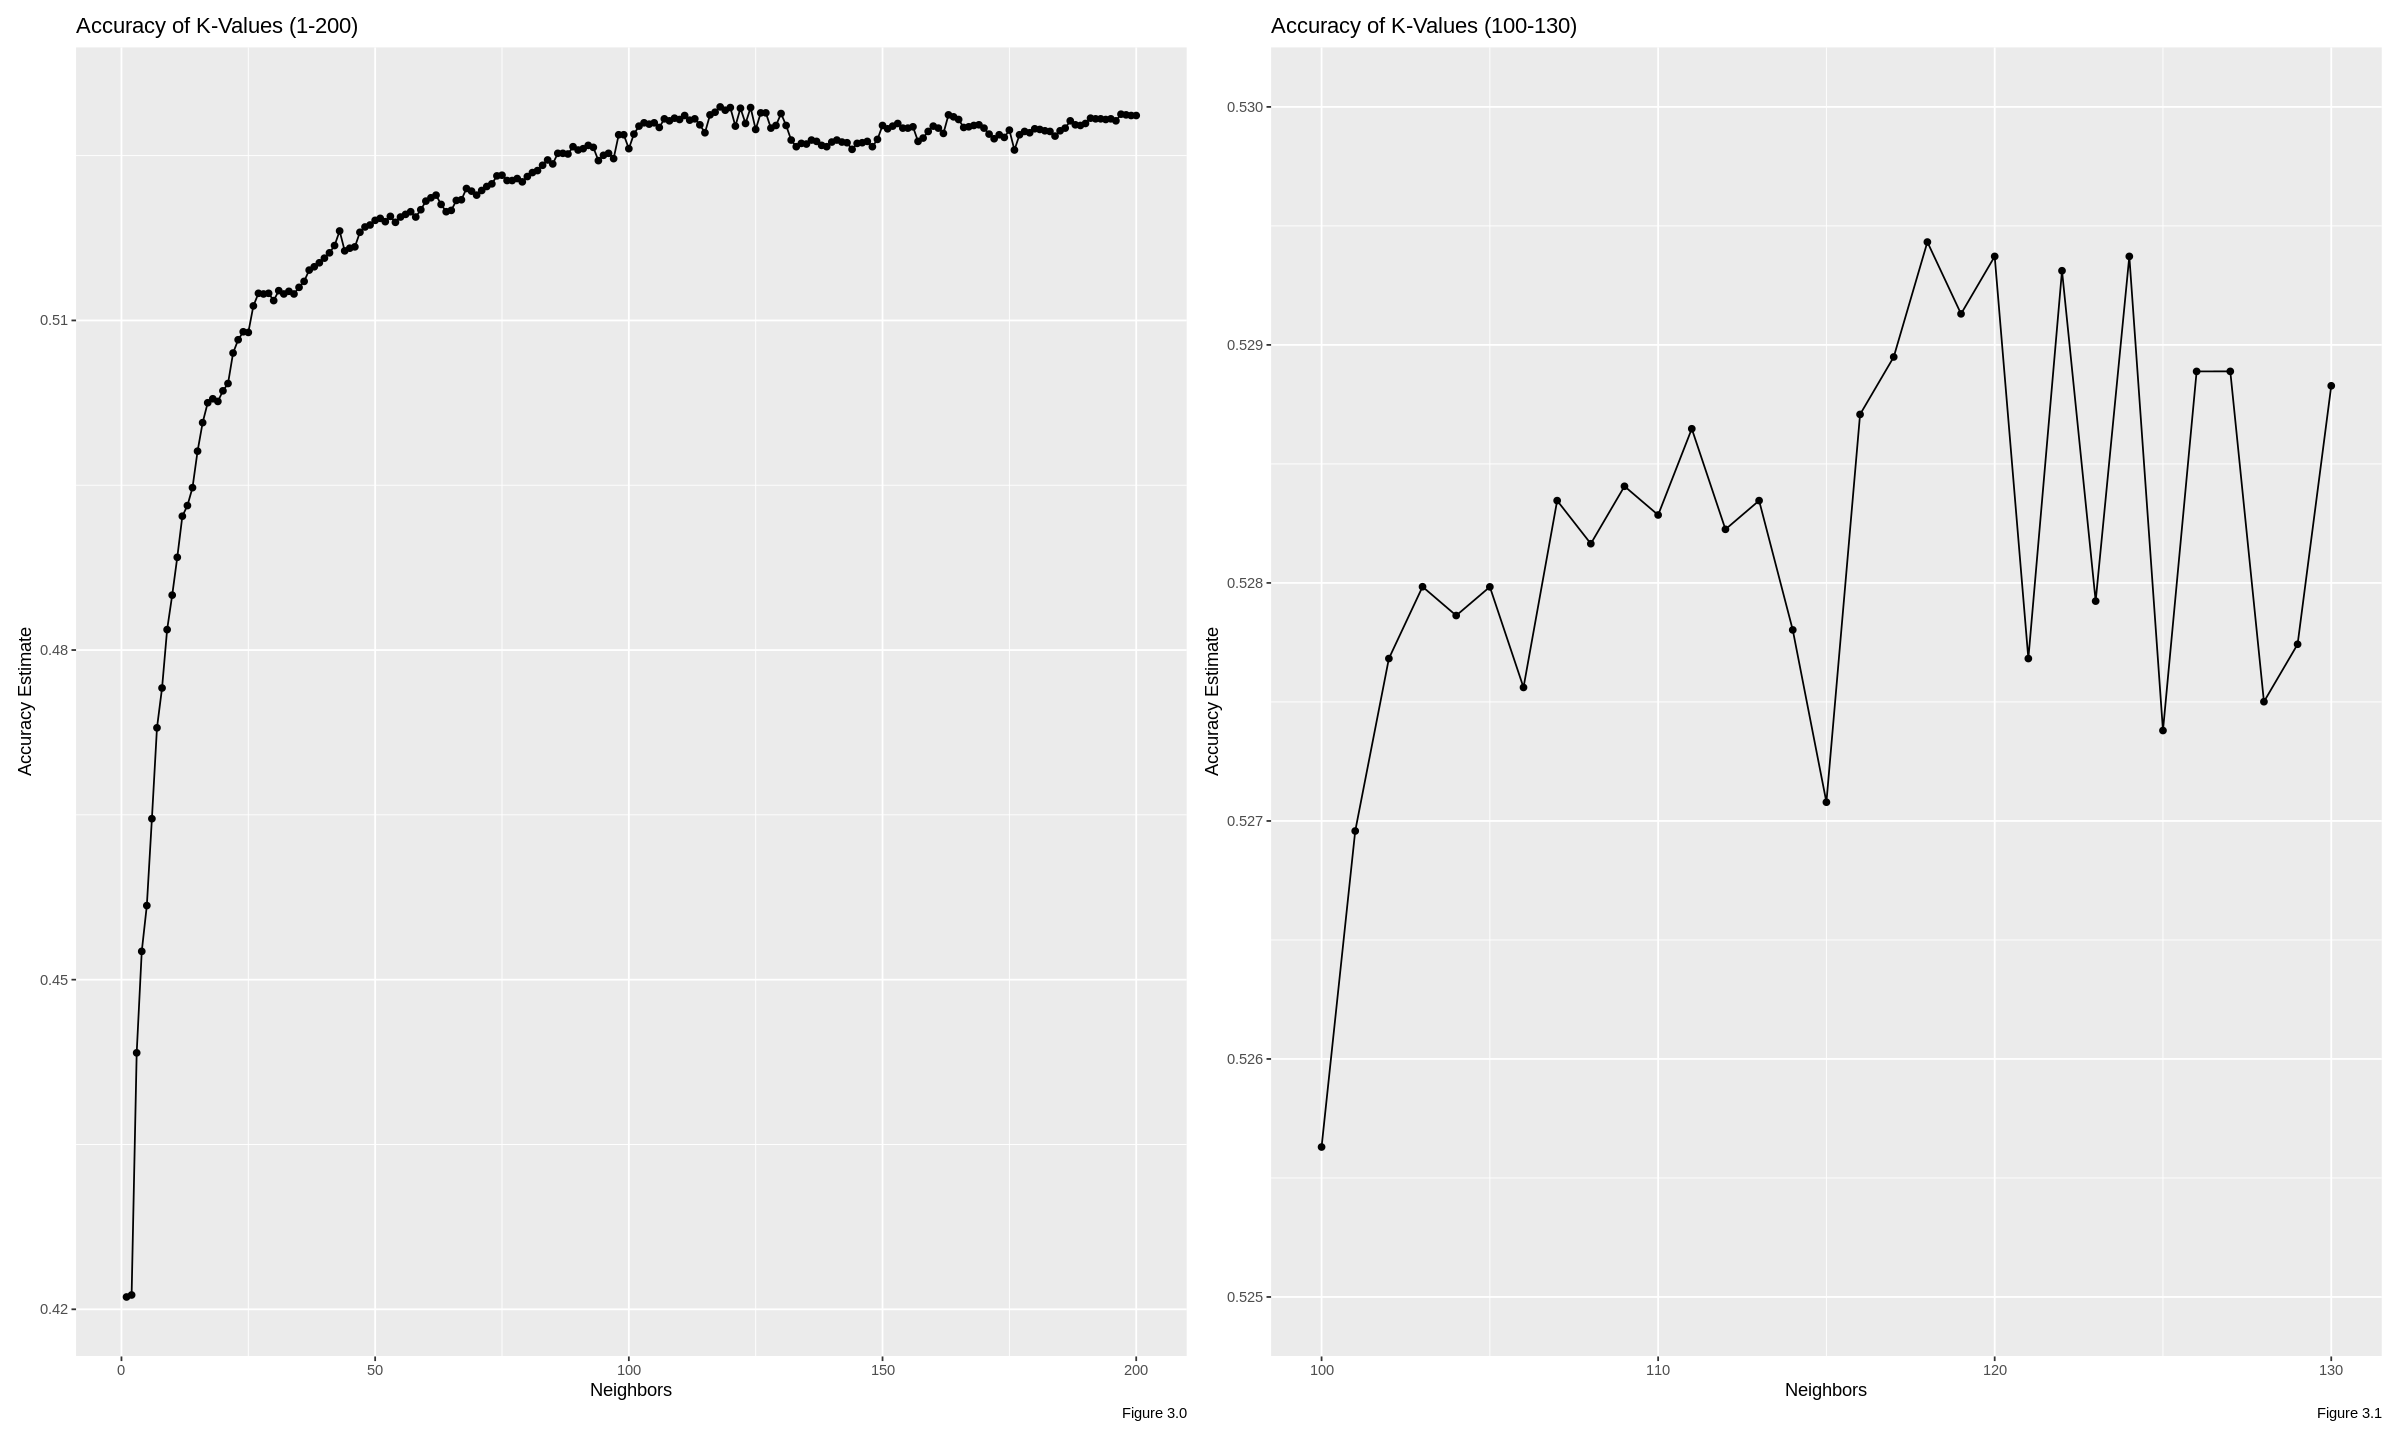

In [60]:
options(repr.plot.width = 20, repr.plot.height = 12)
accuracy_versus_k <- ggplot(knn_accuracy, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate",caption='Figure 3.0') +
      ggtitle('Accuracy of K-Values (1-200)')


accuracy_versus_k0 <- ggplot(knn_accuracy, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate",caption='Figure 3.1') +
      scale_x_continuous(limits = c(100,130)) +
      scale_y_continuous(limits = c(0.525,0.53)) +
      ggtitle('Accuracy of K-Values (100-130)')

accuracy_versus_k + accuracy_versus_k0

#### Training The Model with K=114 and Predicting The Test Data
Now that we've determined 114 to be the most accurate K, we rebuild our workflow on the tuned model. 

In [75]:
knn_118 <- knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = 118) %>%
    set_engine('kknn') %>%
    set_mode('classification')
                                        
credit_fit <- workflow() %>%
            add_recipe(credit_recipe) %>%
            add_model(knn_118) %>%
            fit(data = credit_train)

credit_test_predictions <- predict(credit_fit, credit_test) %>%
    bind_cols(credit_test)

credit_accuracy <- credit_test_predictions %>%
    metrics(truth = EDUCATION, estimate = .pred_class)

credit_accuracy %>%
    set_caption('Table 3.0 Accuracy')

Table 3.0 Accuracy# A tibble: 2 x 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy multiclass     0.527
2 kap      multiclass     0.156

In [65]:
credit_mat <- credit_test_predictions %>%
    conf_mat(truth = EDUCATION, estimate = .pred_class)
credit_mat

          Truth
Prediction    1    2    3
         1 1797 1292  419
         2 2069 4024 1439
         3    0    0    0

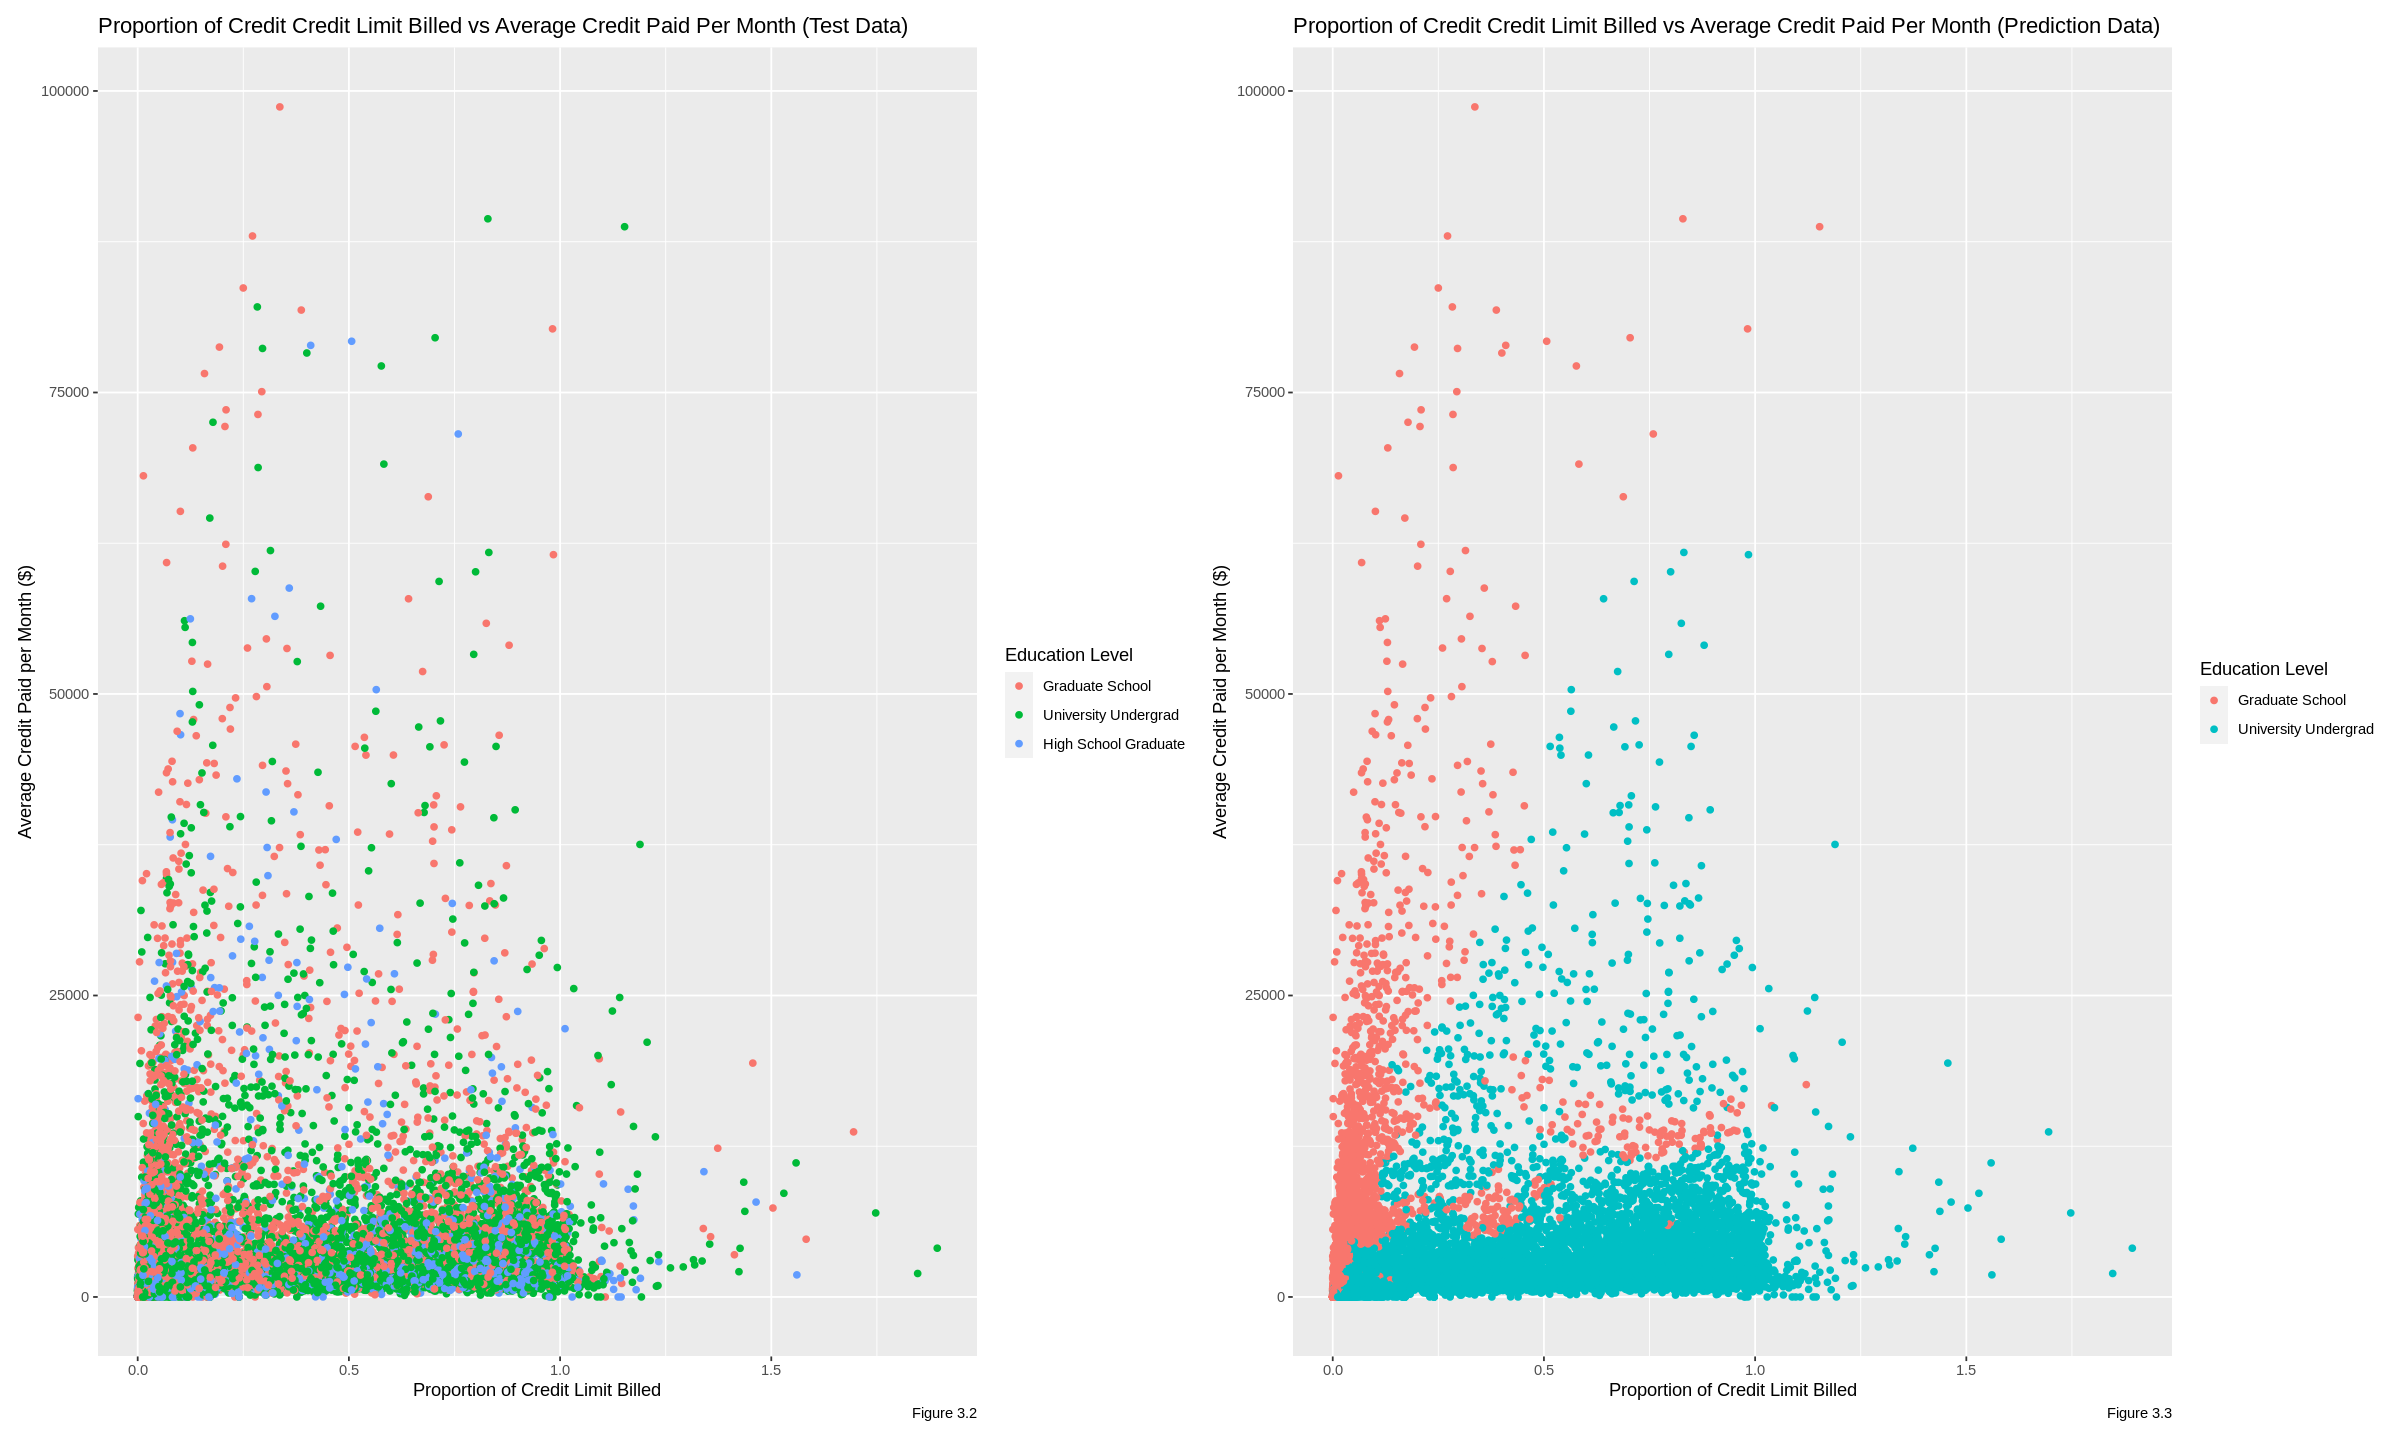

In [81]:
options(repr.plot.width = 20, repr.plot.height = 12)

test_plot <- credit_test %>%
    ggplot(aes(x=BILL_AVG,y=PAY_AVG,colour = EDUCATION)) +
    geom_point() +
    labs(x='Proportion of Credit Limit Billed',y='Average Credit Paid per Month ($)', caption = 'Figure 3.2', colour = "Education Level") +
    ggtitle('Proportion of Credit Credit Limit Billed vs Average Credit Paid Per Month (Test Data)') +
    scale_colour_discrete(labels = c("Graduate School","University Undergrad","High School Graduate"))

prediction_plot <- credit_test_predictions %>%
    ggplot(aes(x=BILL_AVG,y=PAY_AVG,colour = .pred_class)) +
    geom_point() +
    labs(x='Proportion of Credit Limit Billed',y='Average Credit Paid per Month ($)', caption = 'Figure 3.3',colour = "Education Level") +
    ggtitle('Proportion of Credit Credit Limit Billed vs Average Credit Paid Per Month (Prediction Data)') +
    scale_colour_discrete(labels = c("Graduate School","University Undergrad","High School Graduate"))

test_plot + prediction_plot

### Methods:
We are predicting the education level of an individual based on their credit history, looking at the average amount of credit used by the individual (NT dollars) relative to their credit limit and the average amount paid (NT dollars). We will use columns “LIMIT_BAL” and “BILL_AMT*” (* = 1 to 6) to create the predictor “bill_avg”. Also, “PAY_AMT*” (* = 1 to 6) to create the predictor “paid_avg”. We will center and scale the data to ensure the data is tidy. We will convert “EDUCATION” to a categorical variable. Since we have a sufficiently large dataset (30,000 instances), we decided to partition it to 60% training and 40% testing as we believe there is enough data to fit the most appropriate model and evaluate it. We will create a recipe that uses the two predictors, and centers and scales the training data. We proceed to create a model specification with tuning on the number of neighbors, and perform a 5-fold cross-validation. We will then create a workflow analysis that adds the recipe and model specification, defines the tuning to 10 K values, and collects the metrics. We will use a line plot k vs accuracy to visualize and evaluate which k to choose. We can now train the data again by specifying how many neighbors and create a new workflow. Finally, we will use the final model to predict on the testing dataset, calculate the accuracy and the confusion matrix. 

### Expected outcomes and significance:
We expect to find that individuals that spend less relative to their credit limit and pay back more will have higher education levels than those who spend more relative to their credit limit and pay back less. Verifying our prediction could highlight the importance of having an education and how it helps people maintain spending habits. Also, it could disclose information on the relationship between socioeconomic statuses and education. Furthermore,  one could investigate whether individuals with lower education levels will have a greater chance of struggling to repay debts in comparison to individuals with higher education levels. 

### Citations:
1. Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

2. CBC News (2016). Higher education still worth the money, new research suggests. Retrieved from https://www.cbc.ca/news/business/university-college-degree-salary-1.3695254

3. Indeed Editorial Team (2021). Average Salary With vs. Without a College Degree. Retrieved from https://www.indeed.com/career-advice/pay-salary/average-salary-with-college-degree-vs-without